# Introduction

A Naive Bayes classifier is a simple probabilistic classifier based on the Bayes’ theorem along with some strong (naive) assumptions regarding the independence of features. Others have suggested the name “independent feature model” as more fit. For example, a pet may be considered a dog, in a pet classifier context, if it has 4 legs, a tail, and barks. These features (presence of 4 legs, a tail, and barking) may depend on each other. However, the naive Bayes classifier assumes they contribute independently to the probability that a pet is a dog. Naive Bayes classifier is used heavily in text classification, e.g., assigning topics on text, detecting spam, identifying age/gender from text, performing sentiment analysis. Given that there are many well-written introductory articles on this topic, we won’t spend much time in theory.

# The Mathematical Formulation

Given a set of features $x_1,x_2,…,x_n$ and a set of classes $C$
, we want to build a model that yields the value of $P(C_k∣x_1,x_2,…,x_n)$
. Then, by taking the maximum probability over this range of probabilities, we come up with our best estimate for the correct class:
* $C_{\text{predicted}} \\
    = \arg\max_{C_k \in \mathcal{C}} P(C_k \mid x_1, x_2, \dots, x_n) \\
    = \arg\max_{C_k \in \mathcal{C}} \frac{P(x_1, x_2, \dots, x_n \mid C_k) \cdot P(C_k)}{P(x_1, x_2, \dots, x_n)} \\
    = \arg\max_{C_k \in \mathcal{C}} P(x_1, x_2, \dots, x_n \mid C_k) \cdot P(C_k)$ \\

In the second line we applied the Bayes’ theorem $P(A∣B)=P(B∣A)P(A)/P(B)$.
In the last line, we omitted the denominator since it is the same across all classes, i.e., acts merely as a scaling factor. The estimation of $P(C_k)$ is straightforward; we just compute each class’s relative frequency in the training set. However, the calculation of $P(x_1,x_2,…,x_n∣C_k)$ is more demanding. Here comes the “naive” part of the Naive Bayes classifier. We make the assumption that $x_1,x_2,…,x_n$ features are independent. Then, it holds that $P(x_1,x_2,…,x_n∣C_k)=P(x_1∣C_k)P(x_2∣C_k)…P(x_n∣C_k)$ or just $∏_{i=1}^n P(x_i∣C_k)$. This greatly reduces the number of the model’s parameters and simplifies their estimation. So, to sum up, the naive Bayes classifier is the solution to the following optimization problem:
* $C_predicted \ = \ argmax_{C_k ∈ C} P(C_k) * Π_{i=1}^n P(x_i | C_k)$

In the pet example, assuming we had two classes, Cdog and Cmonkey, we would write:
* \[
\begin{align}
P(\text{dog} \mid \text{4-legs}, \text{tail}, \text{barks})
&\propto P(\text{4-legs} \mid \text{dog}) \cdot P(\text{tail} \mid \text{dog}) \cdot P(\text{barks} \mid \text{dog}) \cdot P(\text{dog}) \\
P(\text{monkey} \mid \text{4-legs}, \text{tail}, \text{barks})
&\propto P(\text{4-legs} \mid \text{monkey}) \cdot P(\text{tail} \mid \text{monkey}) \cdot P(\text{barks} \mid \text{monkey}) \cdot P(\text{monkey})
\end{align}
\]

* In Traditional Chinese : \[
\begin{align}
P(狗 | 有4隻腳、有尾巴、會叫) ∝ P(有4隻腳 | 狗) × P(有尾巴 | 狗) × P(會叫 | 狗) × P(狗的先驗機率) \\
P(猴子 | 有4隻腳、有尾巴、會叫) ∝ P(有4隻腳 | 猴子) × P(有尾巴 | 猴子) × P(會叫 | 猴子) × P(猴子的先驗機率)
\end{align}
\]

inally, we would compare the two calculated probabilities to infer whether the pet was a dog or a monkey. Believe it or not, monkeys may bark as well!

All the model’s parameters (the priors for each class and the feature probability distributions) need to be estimated from the training set. The priors can be calculated by the relative frequency of each class in the training set, e.g. $P(C_k) = \frac{\text{\# of samples in class} \cdot C_k} {\text{total \# of samples}}$. The feature probability distributions (or class conditionals) can be approximated with maximum likelihood estimation.

In this post, we will create some trainable Gaussian distributions for the iris data set’s features. We will then have Tensorflow estimate their parameters $(μ,σ)$ by minimizing the negative log-likelihood, which is equivalent to maximizing of log-likelihood. We have already done this in a previous post. Note though, that the feature distributions need not be Gaussian. For instance, in Mathematica’s current implementation, the feature distributions are modeled using a piecewise-constant function:

![image.png](https://ekamperi.github.io/images/naive_bayes/naive_bayes_piecewise.png)

Another example is when the features are assumed to be a binary-valued variable (True/False). In this case, the samples would be represented as binary-valued feature vectors, and we would use a Bernoulli distribution instead of Gaussian. The bottom line is that no matter what distribution we use to model our features, maximum likelihood estimation can be applied to estimate the distribution’s parameters (let it be $p$ in Bernoulli, $λ$ in Poisson, $μ,σ$ in Gaussian, etc.).

# Tensorflow Example with the iris dataset

## Load and Process the data
The iris data set consists of 50 samples from Iris’ three species (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For further information, the reader may refer to R. A. Fisher. “The use of multiple measurements in taxonomic problems”. Annals of Eugenics. 7 (2): 179–188, 1936. Our goal is to construct a Naive Bayes classifier model that predicts the correct class from the sepal length and sepal width features (so, just 2 out of 4 features). This blog post is inspired by a weekly assignment of the course “Probabilistic Deep Learning with TensorFlow 2” from Imperial College London.

![image.png](https://ekamperi.github.io/images/naive_bayes/iris_images.png)

First, we load the iris dataset, select the features that we will be using, create a training and a test set, and plot the data to get a sense of it.

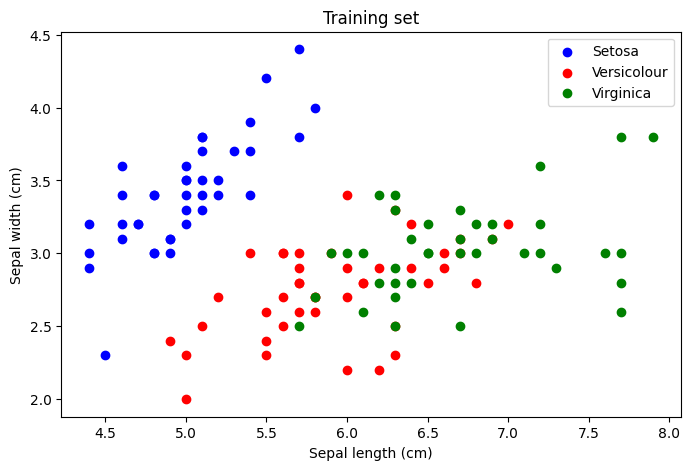

In [1]:
# Import stuff we will be needing
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection

# Load the dataset
iris = datasets.load_iris()

# Use only the first two features: sepal length and width
data = iris.data[:, :2]
targets = iris.target

# Randomly shuffle the data and make train and test splits
x_train, x_test, y_train, y_test = \
    model_selection.train_test_split(data, targets, test_size=0.2)

# Plot the training data
labels = {0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'}
label_colours = ['blue', 'red', 'green']

def plot_data(x, y, labels, colours):
    for y_class in np.unique(y):
        index = np.where(y == y_class)
        plt.scatter(x[index, 0], x[index, 1],
                    label=labels[y_class], c=colours[y_class])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()

plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

## Construct the custom training loop

This code block is probably the single most important of the classifier. Here, we create trainable Gaussian distributions for the data set’s features with tfd.`MultivariateNormalDiag()`. The distributions’ parameters will be estimated by minimizing the negative log-likelihood, which is equivalent to maximizing the log-likelihood.

In [2]:
def learn_parameters(x, y, mus, scales, optimiser, epochs):
    """
    Set up the class conditional distributions as a MultivariateNormalDiag
    object, and update the trainable variables in a custom training loop.
    """
    @tf.function
    def nll(dist, x_train, y_train):
        log_probs = dist.log_prob(x_train)
        L = len(tf.unique(y_train)[0])
        y_train = tf.one_hot(indices=y_train, depth=L)
        return -tf.reduce_mean(log_probs * y_train)

    @tf.function
    def get_loss_and_grads(dist, x_train, y_train):
        with tf.GradientTape() as tape:
            tape.watch(dist.trainable_variables)
            loss = nll(dist, x_train, y_train)
            grads = tape.gradient(loss, dist.trainable_variables)
        return loss, grads

    nll_loss = []
    mu_values = []
    scales_values = []
    x = tf.cast(np.expand_dims(x, axis=1), tf.float32)
    dist = tfd.MultivariateNormalDiag(loc=mus, scale_diag=scales)

    for epoch in range(epochs):
        loss, grads = get_loss_and_grads(dist, x, y)
        optimiser.apply_gradients(zip(grads, dist.trainable_variables))
        nll_loss.append(loss)
        mu_values.append(mus.numpy())
        scales_values.append(scales.numpy())

    nll_loss, mu_values, scales_values = np.array(nll_loss), np.array(mu_values), np.array(scales_values)

    return (nll_loss, mu_values, scales_values, dist)

## Train the model
Next, we assign some initial values to the model’s parameters, instantiate an Adam optimizer, and call the `learn_parameters()` function to actually perform the training.

In [18]:
# Assign initial values for the model's parameters
mus = tf.Variable([[1., 1.], [1., 1.], [1., 1.]])
scales = tf.Variable([[1., 1.], [1., 1.], [1., 1.]])
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
epochs = 10000
nlls, mu_arr, scales_arr, class_conditionals = \
    learn_parameters(x_train, y_train, mus, scales, opt, epochs)

After the training has been completed, we plot the loss vs. epoch to ensure that our optimizer converged. We also plot for the same reasons the values of our model’s parameters.

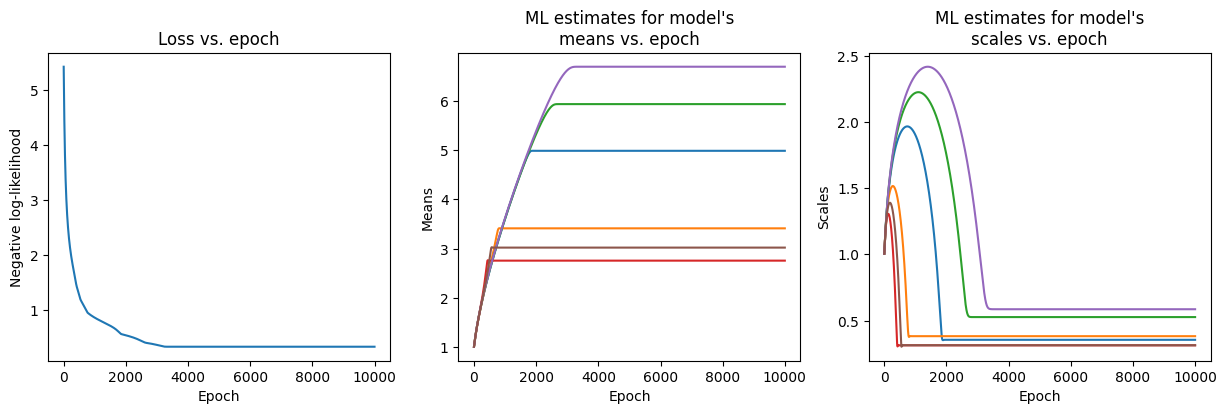

In [19]:
# Plot the loss and convergence of the standard deviation parameters
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(nlls)
ax[0].set_title("Loss vs. epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Negative log-likelihood")
for k in [0, 1, 2]:
    ax[1].plot(mu_arr[:, k, 0])
    ax[1].plot(mu_arr[:, k, 1])
ax[1].set_title("ML estimates for model's\nmeans vs. epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Means")
for k in [0, 1, 2]:
    ax[2].plot(scales_arr[:, k, 0])
    ax[2].plot(scales_arr[:, k, 1])
ax[2].set_title("ML estimates for model's\nscales vs. epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Scales")
plt.show()

Indeed, our training loop achieved convergence, and the model’s parameters settled on their best estimates, even if they all started with the same initial conditions. The following code plots the three bivariate Gaussian distributions for the three classes.

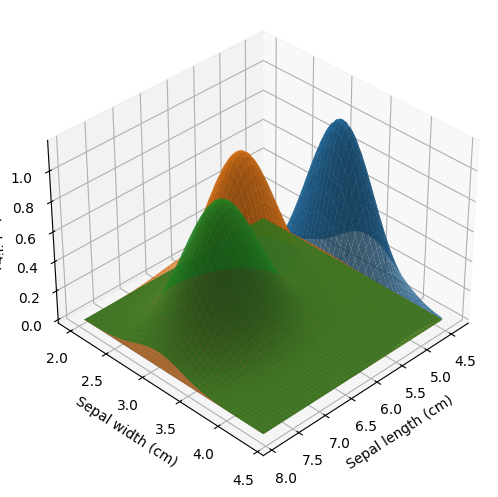

In [20]:
def get_meshgrid(x0_range, x1_range, n_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], n_points)
    x1 = np.linspace(x1_range[0], x1_range[1], n_points)
    return np.meshgrid(x0, x1)

x0_range = x_train[:, 0].min(), x_train[:, 0].max()
x1_range = x_train[:, 1].min(), x_train[:, 1].max()
X0, X1 = get_meshgrid(x0_range, x1_range, n_points=300)
X_v = np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, axis=1)
Z = class_conditionals.prob(X_v)
Z = np.array(Z).T.reshape(3, *X0.shape)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')
for k in [0,1,2]:
    ax.plot_surface(X0, X1, Z[k,:,:], alpha=.8)
ax.set_xlabel('Sepal length (cm)')
ax.set_ylabel('Sepal width (cm)')
ax.set_zlabel('Probability');
ax.elev = 35
ax.azim = 45

We may also print the model’s parameters:

In [21]:
# View the distribution parameters
print("Class conditional means:")
print(class_conditionals.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals.stddev().numpy())
# Class conditional means:
# [[5.002439  3.42439  ]
# [5.89      2.78     ]
# [6.5179486 2.9307692]]

# Class conditional standard deviations:
# [[0.34675348 0.37855995]
# [0.5309426  0.31796226]
# [0.5808357  0.28025055]]

Class conditional means:
[[4.9897437 3.4128203]
 [5.939535  2.755814 ]
 [6.7       3.0210526]]

Class conditional standard deviations:
[[0.35503325 0.38242108]
 [0.52656835 0.31349644]
 [0.5857968  0.3138537 ]]


## Measure model's accuracy
To measure the model’s accuracy, we need to be able to make some predictions, which in turn means that we must be able to calculate:
* $C_\text{predicated}\ = \ arg\ max_{C_k ∈ C}\ P(C_k) \ ∏_{i=1}^n P(x_i \mid C_k)$

Up until now, we have calculated the feature distributions P(xi∣Ck), which is the hardest part. We will now estimate the priors as the relative frequencies of each class in the data set.

In [22]:
def get_prior(y):
    """
    This function takes training labels as a numpy array y of shape (num_samples,) as an input,
    and builds a Categorical Distribution object with empty batch shape and event shape,
    with the probability of each class.
    """
    counts = np.bincount(y)
    dist = tfd.Categorical(probs=counts/len(y))
    return dist

prior = get_prior(y_train)
prior.probs

#    <tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.34166667, 0.33333333, 0.325     ])>

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.325     , 0.35833333, 0.31666667])>

Since we have 3 classes in the data set, we calculated 3 priors: $P(C_1)\ =\ 0.342$, $P(C_2)\ =\ 0.333$, and $P(C_3)\ =\ 0.325$. Next, we will setup a `predict_class()`, that will act as the arg max opetator.

In [23]:
def predict_class(prior, class_conditionals, x):
    def predict_fn(myx):
        class_probs = class_conditionals.prob(tf.cast(myx, dtype=tf.float32))
        prior_probs = tf.cast(prior.probs, dtype=tf.float32)
        class_times_prior_probs = class_probs * prior_probs
        Q = tf.reduce_sum(class_times_prior_probs)       # Technically, this step
        P = tf.math.divide(class_times_prior_probs, Q)   # and this one, are not necessary.
        Y = tf.cast(tf.argmax(P), dtype=tf.float64)
        return Y
    y = tf.map_fn(predict_fn, x)
    return y

# Get the class predictions
# Evaluate the model accuracy on the test set
predictions = predict_class(prior, class_conditionals, x_test)
accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

#    Test accuracy: 0.8667

Test accuracy: 0.7333


So, our model achieved an accuracy of 0.8667 on the test set, which is pretty good, considering that we used only 2 out of the 4 features of the dataset!

## Plot the decision regions
In a classification problem with N classes, a decision boundary is a hypersurface partitioning the feature space into N sets, one for each class. All the points on the same side of the decision boundary are taken to belong to the same category. In our case, we had 2 features and 3 classes;therefore, the classifier partitions the 2D plane into 3 regions. The decision boundary is the area where the predicted label becomes ambiguous.

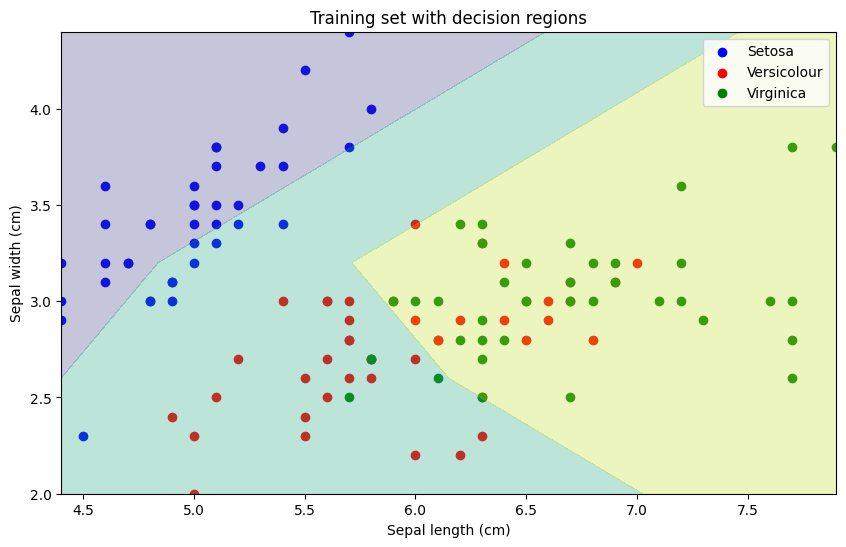

In [24]:
def contour_plot(x0_range, x1_range, prob_fn, batch_shape, levels=None, n_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, n_points=n_points)
    # X0.shape = (100, 100)
    # X1.shape = (100, 100)
    X_values = np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, axis=1)
    # X_values.shape = (1000, 1, 2)
    Z = prob_fn(X_values)
    # Z.shape = (10000, 3)
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    # Z.shape = (3, 100, 100)
    for batch in np.arange(batch_shape):
        plt.contourf(X0, X1, Z[batch], alpha=0.3, levels=levels)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels=labels, colours=label_colours)
contour_plot(x0_range, x1_range,
             lambda x: predict_class(prior, class_conditionals, x),
             1, n_points=3, levels=[-0.5, 0.5, 1.5, 2])
plt.title("Training set with decision regions")
plt.show()

# A note regarding Gaussian distributions

When the feature distributions are Gaussian, there exist analytic solutions for the distributions’ parameters:

* $\hat{\mu}{ik} = \frac{\sum{n} x_i^{(n)} \cdot \delta(y^{(n)} = y_k)}{\sum_{n} \delta(y^{(n)} = y_k)}$

* $\hat{\sigma}{ik} = \sqrt{ \frac{\sum{n} \left( x_i^{(n)} - \hat{\mu}{ik} \right)^2 \cdot \delta(y^{(n)} = y_k)}{\sum{n} \delta(y^{(n)} = y_k)} }$

Where the superscript $(n)$ denotes the nth example of the data set, $δ(y(n)\ =\ y_k)\ =\ 1\ if\ y(n)\ =\ y_k\ and\ 0\ otherwise$, and $N$ is the total number of examples. Note that the above are just the means and standard deviations of the sample data points for each class.


* 補充：
  -	$\hat{\mu}_{i_k}$：特徵 x_i 在類別 y_k 中的平均值
  - $\hat{\sigma}_{ik}$：特徵 x_i 在類別 y_k 中的標準差
  - $x_i^{(n)}$：第 n 筆資料的第 i 個特徵
  - $y^{(n)}$：第 n 筆資料的標籤
  - $\delta(y^{(n)} = y_k)$：當 $y^{(n)}\ =\ y_k$ 時為 1，否則為 0（即指示函數）


In [25]:
def get_analytic_optimal_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs,
    and builds the class conditional Gaussian distributions based on
    analytic solutions for optimal parameters.
    """
    def delta(a, b):
        return 1. if a == b else 0.

    n_samples = len(y)
    mu = []
    sigma = []
    for k in range(3): # Loop over every class
        inner_mu = []
        inner_sigma = []
        for i in range(2): # Loop over every feature
            dyk = [delta(y[r], k) for r in range(n_samples)]
            xin = x[:, i]
            mu_ik = np.dot(xin, dyk) / np.sum(dyk)
            sigma_squared_ik = np.dot((xin - mu_ik)**2, dyk) / np.sum(dyk)
            inner_mu.append(mu_ik)
            inner_sigma.append(np.sqrt(sigma_squared_ik))
        mu.append(inner_mu)
        sigma.append(inner_sigma)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return dist

class_conditionals = get_analytic_optimal_class_conditionals(x_train, y_train)
class_conditionals.loc, class_conditionals.stddev()

# (<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
#  array([[5.00930233, 3.41860465],
#         [5.91081081, 2.78108108],
#         [6.635     , 2.975     ]])>,
#  <tf.Tensor: shape=(3, 2), dtype=float64, numpy=
#  array([[0.32694068, 0.37926233],
#         [0.53966145, 0.32201883],
#         [0.68758636, 0.34332929]])>)

(<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
 array([[4.98974359, 3.41282051],
        [5.93953488, 2.75581395],
        [6.7       , 3.02105263]])>,
 <tf.Tensor: shape=(3, 2), dtype=float64, numpy=
 array([[0.35503331, 0.38242109],
        [0.52656833, 0.31349665],
        [0.5857968 , 0.31385372]])>)

Indeed, the values we got via maximum likelihood estimation are pretty close to the values derived from the analytic solutions!

# Pros and cons of naive Bayes classifier


Advantages of naive Bayes classifier:

* Works quite well in real-world applications.
* Requires only a small amount of training data.
* With each training example, prior and likelihood can be updated in real-time.
* Since it assumes independent variables, only the class variables’ variances need to be estimated and not the entire covariance matrix (i.e., fewer parameters to calculate).
* Fast training and fast inference.
* It gives a probability distribution over all classes (i.e., not just a classification).
* Multiple classifiers may be combined, e.g., by taking the product of their predicted probabilities.
* May be used as a first-line “punching bag” before other smarter algorithms kick in the problem.

Disadvantages:

* More sophisticated models outperform them.

* **以上是高度還原參考網站上的程式碼，以下是第六部分的討論**

# Discussion

1. **A note regarding Gaussian distributions**

在 Naive Bayes 分類器中，當特徵為連續型變數時，常假設這些特徵在每個類別下遵循 Gaussian（正態）分布。這種假設使得我們可以使用最大似然估計（Maximum Likelihood Estimation, MLE）來估計每個類別中每個特徵的平均值（μ）和標準差（σ）。具體而言，對於每個類別 C_k 和特徵 x_i，我們計算：
* 平均值（μ）：
$\hat{\mu}{ik} = \frac{\sum{n} x_i^{(n)} \cdot \delta(y^{(n)} = y_k)}{\sum_{n} \delta(y^{(n)} = y_k)}$
* 標準差（σ）：
$\hat{\sigma}{ik} = \sqrt{ \frac{\sum{n} \left( x_i^{(n)} - \hat{\mu}{ik} \right)^2 \cdot \delta(y^{(n)} = y_k)}{\sum{n} \delta(y^{(n)} = y_k)} }$

其中，$\delta(y^{(n)} = y_k)$ 是指示函數，當第 n 筆資料的標籤為 $y_k$ 時為 1，否則為 0。

這種方法的優點是簡單且計算效率高，但其前提是假設特徵在每個類別下遵循 Gaussian 分布，這在實際應用中可能不總是成立。

---

2. **Pros and cons of naive Bayes classifier**

優點：
	•	簡單易實現：Naive Bayes 是一種簡單且易於實現的分類演算法，適合初學者學習和快速原型開發。
	•	訓練速度快：由於其簡單的假設，Naive Bayes 的訓練速度非常快，適合處理大規模資料集。
	•	對高維資料表現良好：即使在特徵數量很多的情況下，Naive Bayes 也能有效運作。
	•	適用於多類別問題：Naive Bayes 天生支持多類別分類問題。
	•	對缺失資料具有一定的魯棒性：在某些實作中，Naive Bayes 可以處理缺失的特徵資料。

缺點：
	•	特徵獨立性假設過於強烈：Naive Bayes 假設所有特徵在給定類別的情況下是條件獨立的，這在現實中往往不成立，可能影響模型的準確性。
	•	對於類別不平衡的資料表現不佳：當某些類別的樣本數遠少於其他類別時，Naive Bayes 可能偏向預測樣本數多的類別。
	•	對於連續特徵的分布假設可能不準確：如前所述，假設連續特徵遵循 Gaussian 分布可能不符合實際資料的分布情況。
	•	零頻率問題（Zero Frequency Problem）：當測試資料中出現訓練資料未見過的特徵值時，模型可能會給予該類別零機率，導致無法做出預測。這可以透過拉普拉斯平滑（Laplace Smoothing）等方法來解決。